# Sentiment Classification for IMDB Movie Reviews


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from numpy import array
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalMaxPooling1D, Conv1D, SimpleRNN, LSTM, GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report, confusion_matrix


## Loading the Data

You will need to load the reviews. These are provided in the zip.
In addition, you will use pretrained embeddings (GloVe, 100d) which you need to download e.g. from https://nlp.stanford.edu/projects/glove/ .

In [5]:
movie_reviews = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/imdb_sentiment/imdb_data/IMDB Dataset.csv")
movie_reviews.isnull().values.any()
movie_reviews.shape

(50000, 2)

In [6]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

<Axes: xlabel='sentiment', ylabel='count'>

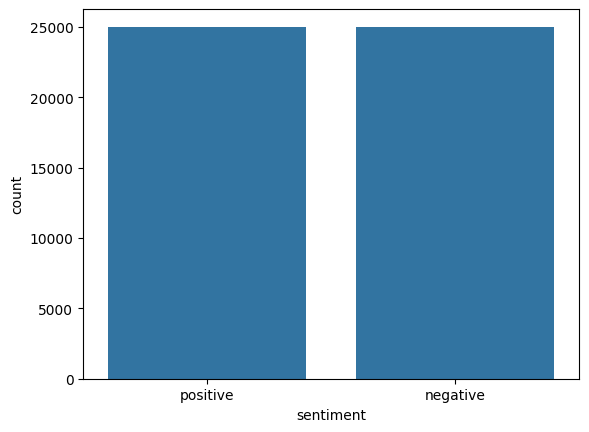

In [8]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)


## Preprocessing

__Prepare the review content__:

Remove
* html tags
* replace punctuation with a space
* remove single characters
* remove multiple spaces

Split into train/test.

Tokenize the reviews - i.e. mapping the words to integers by using a vocabulary of the most frequent words.

Cut and pad the sequences to a given fixed length.

In [9]:
num_words = 5000
maxlen = 100

In [10]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [11]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


In [12]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

Now the above sample review looks as follows - e.g. in teh first sentence, "there's a zombie" is replaced by just "there a zombie"

In [13]:
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

__Prepare the labels__

In [14]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

__Split into train/test__

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

__Tokenize__

In [16]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
vocab_size = len(tokenizer.word_index) + 1
print("Tokenizer has found %i words. When transforming texts to sequences words that have an index above %i are just ignored."%(vocab_size, num_words))

Tokenizer has found 92547 words. When transforming texts to sequences words that have an index above 5000 are just ignored.


In [18]:
indices = [0,1,2,3,4,5,6,4999,5000,10000]
for word, index in tokenizer.word_index.items():
    if index in indices:
        print("%s : %i"%(word,index))

the : 1
and : 2
of : 3
to : 4
is : 5
it : 6
secretly : 4999
joins : 5000
shattering : 10000


In [19]:
tokenizer.texts_to_sequences(["This is %s."%tokenizer.index_word[10000]])

[[8, 5]]

__Cutting and Padding__

In [20]:
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Utility

In [21]:
def performance_plots(model, X_test, Y_test, log, epochs):
    acc = log.history['accuracy']
    val_acc = log.history['val_accuracy']
    print('Train accuracy (end):', acc[-1])
    print('Train accuracy (max):', np.max(acc))
    print('Test accuracy (end) :', val_acc[-1])
    print('Test accuracy (max) :', np.max(val_acc))

    plt.plot(log.history['accuracy'])
    plt.plot(log.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.axis([0,epochs,0.0,1.0])
    plt.show()

    plt.plot(log.history['loss'])
    plt.plot(log.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc = 'upper left')
    plt.axis([0,epochs,0.0,2.0])
    plt.show()

In [22]:
import sklearn
import pandas as pd
activities = ["neg", "pos"]

def confusion_matrix(model, X_test, Y_test):
    scores = model.predict(X_test)
    predictions = np.round(scores)
    labels = Y_test
    cm = sklearn.metrics.confusion_matrix(labels, predictions)
    df = pd.DataFrame({activities[i] : cm[:,i] for i in range(len(activities))}, activities)
    return df

## A First Simple Model: Just an embedding layer and a dense layer

In [23]:
# START YOUR CODE

nepochs = 10
embedding_dim = 50
batchsize = 64

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



# END YOUR CODE

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           4627350   
                                                                 
 flatten (Flatten)           (None, 5000)              0         
                                                                 
 dense (Dense)               (None, 1)                 5001      
                                                                 
Total params: 4632351 (17.67 MB)
Trainable params: 4632351 (17.67 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [24]:
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

Epoch 1/10
625/625 [==============================] - 33s 49ms/step - loss: 0.4481 - accuracy: 0.7884 - val_loss: 0.3229 - val_accuracy: 0.8580
Epoch 2/10
625/625 [==============================] - 8s 12ms/step - loss: 0.2723 - accuracy: 0.8892 - val_loss: 0.3081 - val_accuracy: 0.8631
Epoch 3/10
625/625 [==============================] - 6s 10ms/step - loss: 0.1962 - accuracy: 0.9290 - val_loss: 0.3233 - val_accuracy: 0.8606
Epoch 4/10
625/625 [==============================] - 4s 6ms/step - loss: 0.1155 - accuracy: 0.9725 - val_loss: 0.3466 - val_accuracy: 0.8577
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0580 - accuracy: 0.9926 - val_loss: 0.3795 - val_accuracy: 0.8541
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.0281 - accuracy: 0.9987 - val_loss: 0.4114 - val_accuracy: 0.8521
Epoch 7/10
625/625 [==============================] - 4s 6ms/step - loss: 0.0148 - accuracy: 0.9998 - val_loss: 0.4442 - val_accuracy: 0.8529
Ep

Train accuracy (end): 1.0
Train accuracy (max): 1.0
Test accuracy (end) : 0.8515999913215637
Test accuracy (max) : 0.863099992275238


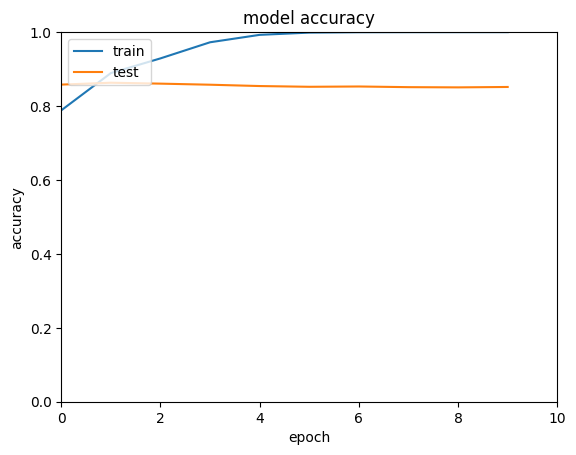

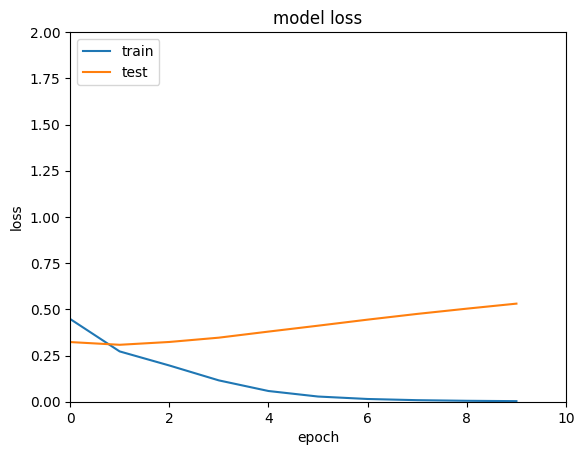

313/313 [==============================] - 0s 1ms/step


,neg,pos
neg,4208,753
pos,731,4308


In [25]:
performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)

We easily get into the overfitting regime since we have a huge amount of parameters.

## Using GloVe as pretrained embedding

In [29]:
embeddings_dictionary = dict()
glove_file = open('/content/drive/MyDrive/Colab Notebooks/imdb_sentiment/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [30]:
embedding_matrix = np.zeros((num_words, maxlen))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None and index<num_words:
        embedding_matrix[index] = embedding_vector

In [32]:
# START YOUR CODE
nepochs = 20
embedding_dim = 100
batchsize = 32
embedding_layer = Embedding(num_words, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=False)

model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# END YOUR CODE

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          500000    
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 510001 (1.95 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 500000 (1.91 MB)
_________________________________________________________________
None


Epoch 1/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.5926 - accuracy: 0.6914 - val_loss: 0.5355 - val_accuracy: 0.7381
Epoch 2/20
1250/1250 [==============================] - 3s 3ms/step - loss: 0.5001 - accuracy: 0.7635 - val_loss: 0.5448 - val_accuracy: 0.7437
Epoch 3/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.4709 - accuracy: 0.7777 - val_loss: 0.5573 - val_accuracy: 0.7411
Epoch 4/20
1250/1250 [==============================] - 3s 3ms/step - loss: 0.4551 - accuracy: 0.7904 - val_loss: 0.5643 - val_accuracy: 0.7432
Epoch 5/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.4439 - accuracy: 0.7962 - val_loss: 0.5803 - val_accuracy: 0.7434
Epoch 6/20
1250/1250 [==============================] - 5s 4ms/step - loss: 0.4295 - accuracy: 0.8042 - val_loss: 0.5929 - val_accuracy: 0.7384
Epoch 7/20
1250/1250 [==============================] - 3s 3ms/step - loss: 0.4284 - accuracy: 0.8044 - val_loss: 0.6047 - val_accuracy:

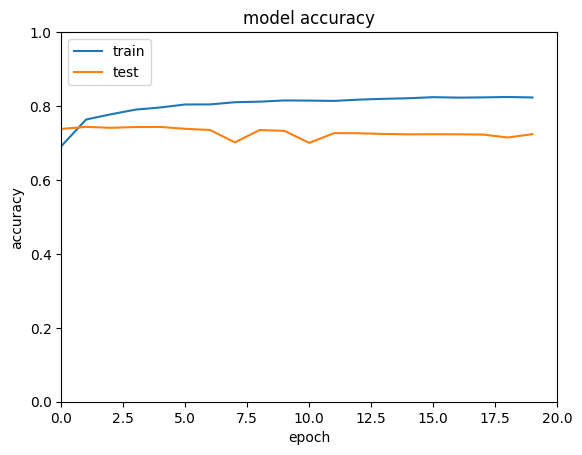

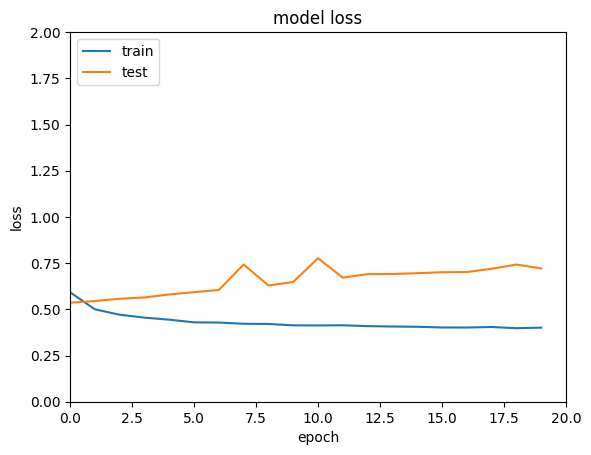

313/313 [==============================] - 0s 1ms/step


,neg,pos
neg,3529,1432
pos,1328,3711


In [33]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=nepochs, verbose=1, validation_data=(X_test, y_test))

performance_plots(model, X_test, y_test, history, nepochs)
confusion_matrix(model, X_test, y_test)


## Further Model / Hyper Parameter Combinations

Examples:

* Pretrained embedding (with GloVe), possibly fine-tuned
* dito + (SimpleRNN | LSTM | GRU | Conv1D)
* dito + stacked layers

For each combination, specify a cell with the model specification, one with the training and one with the evaluation (use for the latter the utilities provided).  


In [38]:
def create_model(architecture='SimpleRNN'):
    model = Sequential()
    model.add(Embedding(num_words, embedding_dim, input_length=maxlen))
    if architecture == 'SimpleRNN':
        model.add(SimpleRNN(32))
    elif architecture == 'LSTM':
        model.add(LSTM(32))
    elif architecture == 'GRU':
        model.add(GRU(32))
    elif architecture == 'Conv1D':
        model.add(Conv1D(32, 7, activation='relu'))
        model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.layers[0].set_weights([embedding_matrix])
    model.layers[0].trainable = False
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

architectures = ['LSTM', 'GRU', 'Conv1D', 'SimpleRNN']

results = {}

for arch in architectures:
    print(f"Training model with {arch}")
    model = create_model(architecture=arch)
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print(classification_report(y_test, y_pred))
    results[arch] = classification_report(y_test, y_pred, output_dict=True)
    print(confusion_matrix(y_test, y_pred))

Training model with LSTM
Epoch 1/10
1000/1000 [==============================] - 10s 8ms/step - loss: 0.5268 - accuracy: 0.7330 - val_loss: 0.4545 - val_accuracy: 0.7815
Epoch 2/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.4173 - accuracy: 0.8075 - val_loss: 0.3826 - val_accuracy: 0.8285
Epoch 3/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.3733 - accuracy: 0.8317 - val_loss: 0.3784 - val_accuracy: 0.8291
Epoch 4/10
1000/1000 [==============================] - 6s 6ms/step - loss: 0.3488 - accuracy: 0.8462 - val_loss: 0.3976 - val_accuracy: 0.8135
Epoch 5/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.3307 - accuracy: 0.8543 - val_loss: 0.3497 - val_accuracy: 0.8474
Epoch 6/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.3144 - accuracy: 0.8623 - val_loss: 0.3355 - val_accuracy: 0.8528
Epoch 7/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.3004 - accuracy: 0.8698 - val_lo

## Report with your Findings

       Model  Precision  Recall  F1-Score  Accuracy
0       LSTM   0.862502  0.8623  0.862295    0.8623
1        GRU   0.858569  0.8553  0.854904    0.8553
2     Conv1D   0.824608  0.8246  0.824602    0.8246
3  SimpleRNN   0.661271  0.6606  0.660047    0.6606


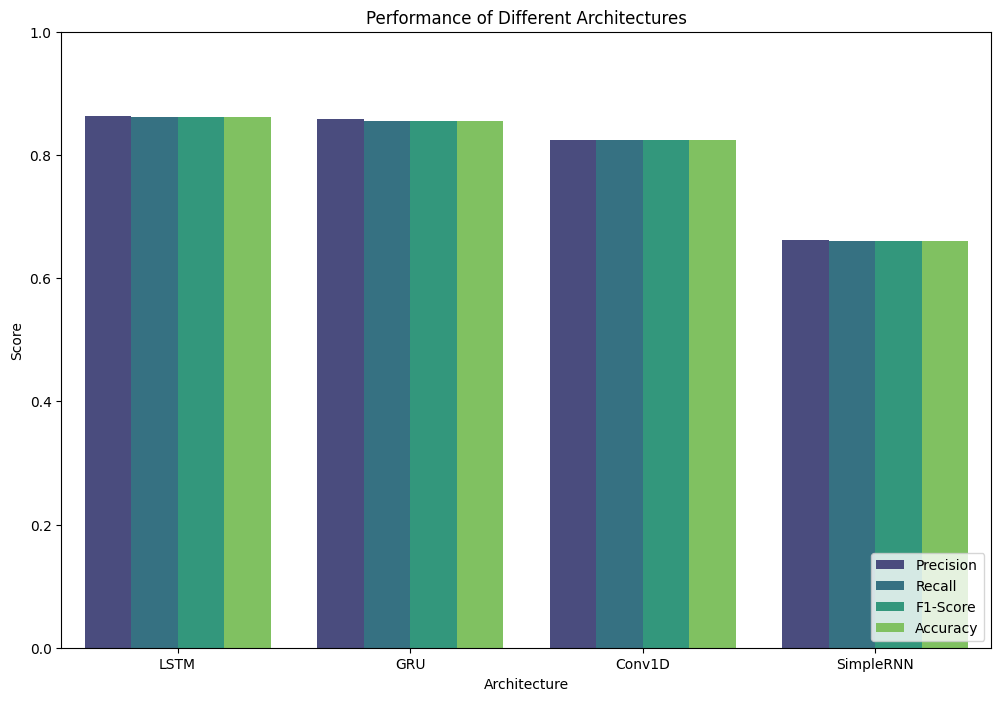

In [40]:
# Transform the results dictionary into a DataFrame
results_transformed = {
    'Model': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Accuracy': []
}

for model_name, metrics in results.items():
    results_transformed['Model'].append(model_name)
    results_transformed['Precision'].append(metrics['weighted avg']['precision'])
    results_transformed['Recall'].append(metrics['weighted avg']['recall'])
    results_transformed['F1-Score'].append(metrics['weighted avg']['f1-score'])
    results_transformed['Accuracy'].append(metrics['accuracy'])

results_df = pd.DataFrame(results_transformed)

# Print the DataFrame for verification
print(results_df)

# Plot the results for better visualization
plt.figure(figsize=(12, 8))
results_melted = results_df.melt(id_vars=['Model'], value_vars=['Precision', 'Recall', 'F1-Score', 'Accuracy'],
                                 var_name='Metric', value_name='Score')
sns.barplot(data=results_melted, x='Model', y='Score', hue='Metric', palette='viridis')
plt.title('Performance of Different Architectures')
plt.xlabel('Architecture')
plt.ylabel('Score')
plt.ylim(0, 1)  # Ensuring the y-axis ranges from 0 to 1 for better comparison
plt.legend(loc='lower right')
plt.show()

The performance comparison of different architectures for a sentiment analysis task shows that LSTM is the best model with the highest scores in Precision, Recall, F1-Score, and Accuracy (all around 0.86). GRU follows closely with slightly lower scores (around 0.85). Conv1D performs moderately well (around 0.82), while SimpleRNN has the lowest performance across all metrics (around 0.66). Thus, LSTM and GRU are more effective than Conv1D and SimpleRNN for this task.